# 06. PyTorch Transfer Learning

Apa itu transfer learning?

Transfer learning melibatkan pengambilan parameters dari satu model yang dipakai di datasetlain, dan kita aplikasikan ke masalah kita

- Pretrained Model = Foundation Models


In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113torch version: 2.6.0+cu118
torchvision version: 0.21.0+cu118



Sekarang kita sudah mendapatkan versi yang kita inginkan dari torch dan torchversion.


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

# # Try to import the going_modular directory, download it from GitHub if it doesn't work
# try:
#     from going_modular.going_modular import data_setup, engine
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
#     !git clone https://github.com/mrdbourke/pytorch-deep-learning
#     !mv pytorch-deep-learning/going_modular .
#     !rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine

In [3]:
from going_modular.going_modular import data_setup, engine

d:\UNSRI_DATA\MACHINE LEARNING\pytorch_course\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Setup device agnostik
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get Data

Mari kita ambil data pizza, steak, sushi kita


In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.


In [6]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Buat Datasets dan DataLoaders

Sekrang setelah kita mendapatkan data, kita akan mengubahnya menjadi PyTorch Dataloaders.

Untuk melakukannya kita bisa menggunakan `data_setup.py`

Ketika kita memuat data, kita harus berfikir tentang bagaimana transformnya

Dan dengan `torchvision` ada 2 cara:

1. Transforms yang dibuat manual - Kita yang mendefenisikan sendiri
2. Transform yang terbuat otomatis - Transforms yang di definiskan oleh model yang kita gunakan sekarang

Kita menggunakan pretrained model, adalah penting, data yang melewati itu diubah ke cara yang sama denga model tersebut dilatih


In [7]:
from going_modular.going_modular import data_setup

### 2.1 Membuat transformasi untuk `torchvision.model` (Manual)

Semua model yang sudah dilatih sebelumnya mengharapkan gambar input dinormalisasi dengan cara yang sama, yaitu mini-batch dari gambar RGB 3-saluran dengan bentuk (3 x H x W), di mana H dan W diharapkan setidaknya 224.

Gambar-gambar tersebut harus dimuat dalam rentang [0, 1] dan kemudian dinormalisasi menggunakan mean = [0.485, 0.456, 0.406] dan std = [0.229, 0.224, 0.225].


In [8]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  normalize
])

In [9]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x236d535a450>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Membuat transform untuk `torchvision.model` (Otomatis)

Catatan: Mulai dari torchvision v0.13+, ada pembaruan tentang bagaimana transformasi data dapat dibuat menggunakan torchvision.models.Saya menyebut metode sebelumnya sebagai "pembuatan manual" dan metode baru sebagai "pembuatan otomatis".


In [10]:
import torchvision
torchvision.__version__

'0.21.0+cu118'

In [11]:
# Ambil pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" weights yang bagus
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
# Ambil trasnform untuk membnuat pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
# BUat DataLoader dengan tranforms otomatis
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x236db61b650>,
 ['pizza', 'steak', 'sushi'])

Eksperimen, eksperimen, eksperimen!

Gagasan utama dari transfer learning adalah mengambil model yang sudah berkinerja baik dari ruang masalah yang serupa dengan milikmu, lalu sesuaikan dengan masalahmu sendiri.

Ada tiga hal yang perlu dipertimbangkan:

- Kecepatan - Seberapa cepat model tersebut perlu berjalan?
- Ukuran - Seberapa besar model tersebut?
- Kinerja - Seberapa baik model tersebut berfungsi pada masalah yang dipilih? (misalnya, seberapa baik model tersebut mengklasifikasikan gambar makanan? untuk FoodVision Mini)

Di mana model tersebut berada?

- Pada perangkat: Seperti pada mobil tanpa pengemudi, di mana pemrosesan real-time sangat penting.
- Pada server: Untuk skenario di mana model dapat di-hosting di server dan diakses dari jarak jauh.

Eksperimen dengan faktor-faktor ini akan membantumu menemukan keseimbangan terbaik untuk kasus penggunaanmu. Jika ada yang ingin ditanyakan lebih lanjut, beri tahu saya ya! 😊


## 3.2 Menyiapkan model pretrained


In [14]:
# Metode lama untuk membuat pretrained model
# model = torchvision.models.efficientnet_b0(pretrained=True)

# Metode bary untuk menyiapkan model pretrained
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device=device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [16]:
model.classifier

# 1000 karena dia mengklasifikasikan 1000 gambar

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Ambil kesimpulan dari model kita `torchinfo.summary())`


In [17]:
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Membekukan model base dan merubah lyyaer ouput untuk menyyyesuaikan kebutuhan kita

Dengan fitur ekstrasi, kita bisa membekukan base layer, dan mengubah output layer


In [18]:
# Bekukan semua base layer EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [19]:
# Update classifier
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [20]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [21]:
## 4. Train model

In [22]:
# Definisikan loss dan optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

In [30]:
# import fungsi latih
from going_modular.going_modular import engine

# set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Siapkan latih dan simpan
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

 20%|██        | 1/5 [00:02<00:09,  2.40s/it]

Epoch: 1 | train_loss: 0.2477 | train_acc: 0.9727 | test_loss: 0.3875 | test_acc: 0.8456


 40%|████      | 2/5 [00:04<00:06,  2.26s/it]

Epoch: 2 | train_loss: 0.2229 | train_acc: 0.9805 | test_loss: 0.3555 | test_acc: 0.8561


 60%|██████    | 3/5 [00:06<00:04,  2.25s/it]

Epoch: 3 | train_loss: 0.2074 | train_acc: 0.9805 | test_loss: 0.3641 | test_acc: 0.8248


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

Epoch: 4 | train_loss: 0.2905 | train_acc: 0.8594 | test_loss: 0.3532 | test_acc: 0.8561


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]

Epoch: 5 | train_loss: 0.2042 | train_acc: 0.9844 | test_loss: 0.3734 | test_acc: 0.8561


In [33]:
from going_modular.going_modular.helper_functions import plot_loss_curves, pred_and_plot_image

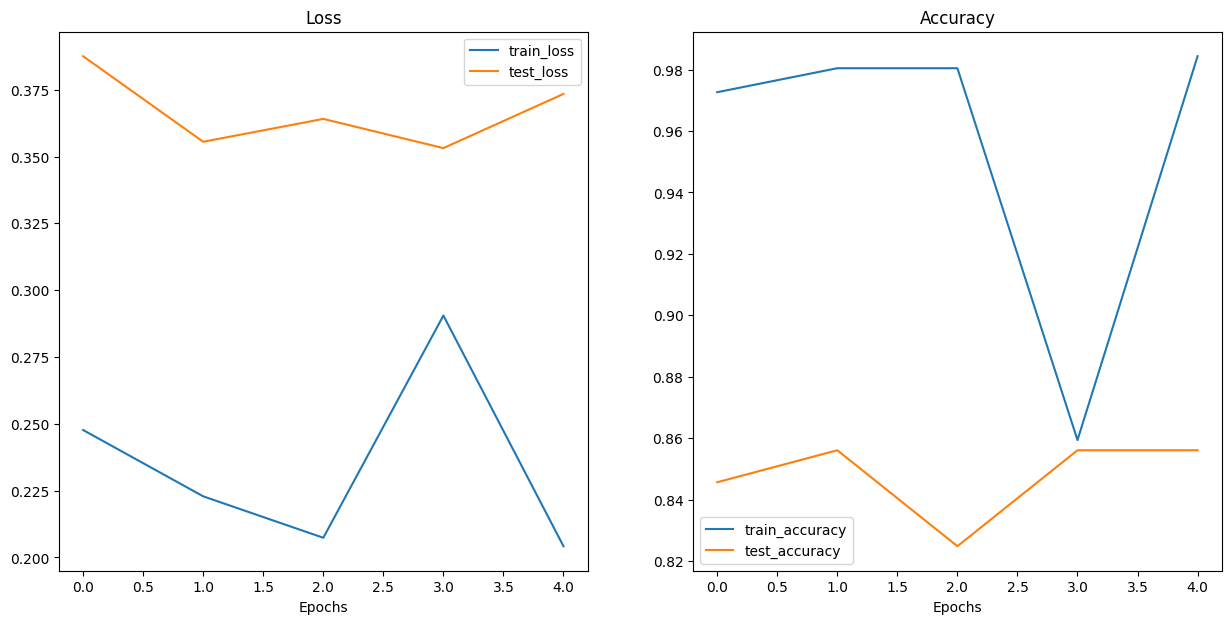

In [32]:
plot_loss_curves(results=results)

## 6. Buat prediksi dari images yang kita dapat dari data test

Buat prediksi kualitatif dari test set kita. Kita akan memastikan bahwa data test kita

- Memiliki bentuk yang sama
- Memiliki datatype yang sama
- Berada di device yang sama
- Melewati proses transform yang sama

Langkah langkah

1. Ambil beberapa hal dari model kita
   1. Model yang sudah kita latih
   2. Nama kelasnya
   3. File path ke target gambarnya
   4. Besar gambarnyya
   5. Transform gambarnya
   6. Informasi devicenya
2. Buka gambar dengan `PIL.Image.Open()`
3. Buat proses transformasi jika belum ada
4. Pastikan model berada di device yang sama
5. Ubah model ke `model.eval()` untuk memastikan siap di inferensi
6. Transformasi gambar target untuk memastikan dimensinya sama dan tepat
7. Buat prediksi dengan memberikan gambar ke model
8. Konversikan logit keluaran model menjadi probabilitas prediksi dengan torch.softmax().
9. Konversikan probabilitas prediksi model menjadi label prediksi dengan torch.argmax().
10. Plot gambar dengan matplotlib dan tetapkan judulnya dengan label prediksi dari langkah 9 dan probabilitas prediksi dari langkah 8.


In [36]:
from typing import List, Tuple

from PIL import Image

# 1. Ambil trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
        
        img = Image.open(image_path)
        
        if transform is not None:
             image_transform = transform
        else:
             image_transform = transforms.Compose([
                   transforms.Resize(image_size),
                   transforms.ToTensor(),
                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
        ])

        ### Predict on image ### 

        # 4. Make sure the model is on the target device
        model.to(device)

        # 5. Turn on model evaluation mode and inference mode
        model.eval()
        with torch.inference_mode():
          # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
          transformed_image = image_transform(img).unsqueeze(dim=0)

          # 7. Make a prediction on image with an extra dimension and send it to the target device
          target_image_pred = model(transformed_image.to(device))

        # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        # 9. Convert prediction probabilities -> prediction labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

        # 10. Plot image with predicted label and probability 
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
        plt.axis(False);
  
  

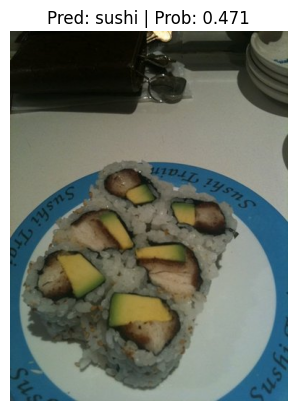

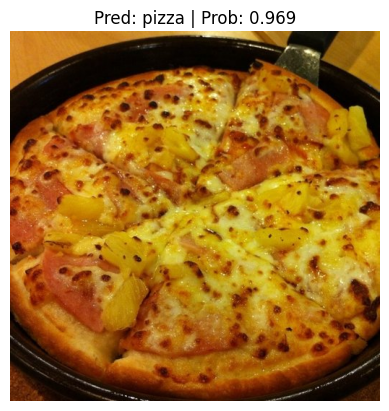

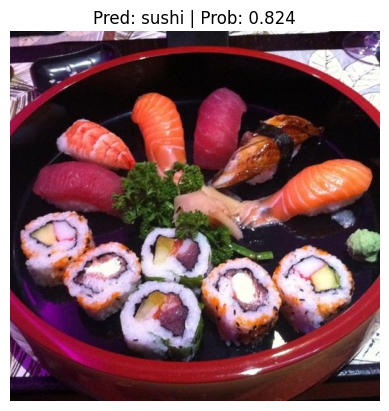

In [56]:
# Ambil random list dari image paths
import random

num_images_to_plot = 3

test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Buat prediksi dan plot gambar
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 Buat prediksi dari gambar kustom


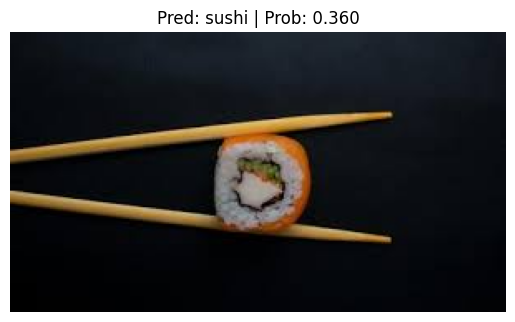

In [58]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "sushi4.png"


# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)